In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import files

In [ ]:
df=pd.read_csv('/content/sample_data/NYSDOH_clean2.csv')

In [ ]:
df=df.drop(['Unnamed:_0','Unnamed: 0'],axis=1)

In [ ]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County',
       'Operating_Certificate_Number', 'Permanent_Facility_Id',
       'Facility_Name', 'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race',
       'Length_of_Stay', 'Type_of_Admission', 'Patient_Disposition',
       'Discharge_Year', 'CCS_Diagnosis_Code', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Code', 'CCS_Procedure_Description', 'APR_DRG_Code',
       'APR_DRG_Description', 'APR_MDC_Code', 'APR_MDC_Description',
       'APR_Severity_of_Illness_Code', 'APR_Severity_of_Illness_Description',
       'APR_Risk_of_Mortality', 'APR_Medical_Surgical_Description',
       'Payment_Typology_1', 'Payment_Typology_2', 'Payment_Typology_3',
       'Birth_Weight', 'Abortion_Edit_Indicator',
       'Emergency_Department_Indicator', 'Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges', 'Length_groups'],
      dtype='object')

In [ ]:
df.shape

(118049, 35)

In [ ]:
# Drop columns that will not be relevant to predicting length of stay, will be repetitive of information in other columns,codes or status determined at discharge or toward discharge
df=df.drop(['Operating_Certificate_Number', 'Permanent_Facility_Id','Patient_Disposition',
       'Discharge_Year','APR_DRG_Code',
       'APR_DRG_Description', 'APR_MDC_Code', 'APR_MDC_Description',
       'APR_Severity_of_Illness_Code', 'APR_Severity_of_Illness_Description',
       'APR_Risk_of_Mortality', 'APR_Medical_Surgical_Description','Payment_Typology_2', 'Payment_Typology_3',
       'Birth_Weight', 'Abortion_Edit_Indicator','Total_Charges', 'Total_Costs',
       'Ratio_of_Total_Costs_to_Total_Charges'],axis=1)

In [ ]:
df.columns

Index(['Hospital_Service_Area', 'Hospital_County', 'Facility_Name',
       'Age_Group', 'Zip_Code__3_digits', 'Gender', 'Race', 'Length_of_Stay',
       'Type_of_Admission', 'CCS_Diagnosis_Code', 'CCS_Diagnosis_Description',
       'CCS_Procedure_Code', 'CCS_Procedure_Description', 'Payment_Typology_1',
       'Emergency_Department_Indicator', 'Length_groups'],
      dtype='object')

In [ ]:
# Create length of stay bins, For 1 day: 24 hour stay, 2-5 days(below mean),
# 6-20 days(above mean to 20),21 to 90 days(short term rehab hospital stay common durations) 
# and 90+ days(long term faciltities). The upper limits of the ranges were used
bins=[-np.inf,1,5,20,90,np.inf]
#bin labels
labels=['0-1','2-5','6-20','21-90','91-120']
df['length_groups']=pd.cut(df['Length_of_Stay'],bins,labels=labels)

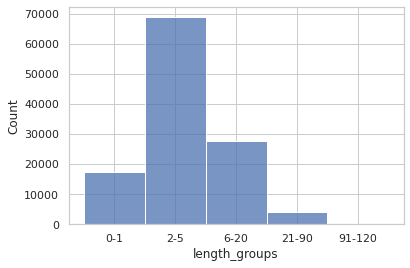

In [ ]:
sns.histplot(x=df['length_groups'])
plt.show()

In [ ]:
# remap age groups
dict={'70 or Older':80, '50 to 69':60,'30 to 49':40 , '18 to 29':20, '0 to 17':10}
df=df.replace({'Age_Group':dict})
df.Age_Group.unique()

array([40, 20, 10, 80, 60])

In [ ]:
# Rename 'Length_groups' (binary) to 'Below_Above_Mean', keep 'length_groups' column for multiclass length groups
df.rename(columns={'Length_groups': 'Below_Above_mean'}, inplace=True)

In [ ]:
# CCS procedure code provides same information as the description, drop procedure codes
df=df.drop('CCS_Procedure_Code',axis=1)

In [ ]:
# drop CCS diagnosis Codes and keep description
df=df.drop('CCS_Diagnosis_Code',axis=1)

In [ ]:
#create a column with mean length of stay for each diagnosis group:MeanLOS_byD
dfdiag=df.groupby('CCS_Diagnosis_Description')['Length_of_Stay'].mean().reset_index()
dfdiag.rename(columns={'Length_of_Stay':'Diag_mean'},inplace=True)
dfdiag.shape
df['MeanLOS_byD']=df['CCS_Diagnosis_Description']
listk=dfdiag['CCS_Diagnosis_Description'].tolist()
d={}
# COnvert to dictionary
d = {listk[i]: listv[i] for i in range(len(listk))}
df=df.replace({'MeanLOS_byD':d})

In [ ]:
# Create a column mean length of stay by procedure: MeanLOS_byP
df['MeanLOS_byP']=df['CCS_Procedure_Description']
dfproc=df.groupby('CCS_Procedure_Description')['Length_of_Stay'].mean().reset_index()
dfproc.rename(columns={'Length_of_Stay':'Proc_mean'},inplace=True)
listK=dfproc['CCS_Procedure_Description'].tolist()
listV=dfproc['Proc_mean'].tolist()
d={listK[i]:listV[i] for i in range(len(listK))}
df=df.replace({'MeanLOS_byP':d})

The binary column (Below_Above_mean) will be used as target varaible column during modelling, the rest of columns with lenth of stay will be dropped. For modelling the X features will be converted to dummy variables as per the machine learning model requirements.

In [ ]:
# save and download the file: nysdoh_feature.csv
df.to_csv('nysdoh_feature.csv')
files.download('nysdoh_feature.csv')